# HW 9, Assignment 1
## Author: Sofiya Elyukin
### Collaborated with: Sebastian Bana, Scott Smith, Ben Alpert, Luis Fernando Melchor, and Jonathan Geis. The code is a combination of my own work,  snippets from the instructions in https://github.com/fedhere/PUI2016_fb55/blob/master/HW9_fb55/subway_timeseries_instructions.ipynb, and code from Sebastian and Luis's notebooks.

In [1]:
# import modules
from __future__ import print_function
import json
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
import pylab as pl

%pylab inline

#plotParams = json.load( open(os.getenv('PUI2016')+'/matplotlibrc.json') )
#pl.rcParams.update(plotParams)

Populating the interactive namespace from numpy and matplotlib


In [16]:
#from https://github.com/fedhere/UInotebooks/blob/master/visz/some_colors_and_shapes.ipynb 
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#00538A', # Strong Blue
    '#FF6800', # Vivid Orange
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#C10020', # Vivid Red
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#A6BDD7', # Very Light Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

newparams = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#aaaaaa", #light gray
  "patch.linewidth": 1.0,
  "legend.fancybox": 'false',
  "axes.color_cycle": kelly_colors_hex,
  "axes.facecolor": "#ffffff", #white
  "axes.labelsize": "small",
  "axes.grid": 'false',
  "patch.edgecolor": "#555555", #dark gray
  "axes.titlesize": "x-large",
  "svg.embed_char_paths": "path",
  "font.size": 10  
  #"legend.fontsize": "small"
  #"axes.grid": 'true' 
}
pl.rcParams.update(newparams)

In [3]:
# Get data

url = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW9_fb55/MTA_Fare.npy'
os.system("curl -O " + url)
os.system("mv MTA_Fare.npy " + os.getenv("PUIDATA") + "/MTA_Fare.npy")
MTArides = np.load(os.getenv("PUIDATA") + '/MTA_Fare.npy')

In [4]:
print (MTArides.shape)
print ('There are', MTArides.shape[0], 'stations', MTArides.shape[1], 'card types, and', MTArides.shape[2], 
       'weeks in this dataset.')

(600, 23, 194)
There are 600 stations 23 card types, and 194 weeks in this dataset.


In [5]:
# Missing  data is entered as -1. Change to NaN
MTArides = MTArides.astype(np.float, copy = False)
MTArides[MTArides == -1] = np.nan

In [6]:
# Array for metrocard types
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

# Create a date range
# 5/21/2010 was a Friday, adjusted daterange for following Sunday (gives accurate week later for event detection)
rng = pd.date_range('5/30/2010', periods=194, freq='W')

In [7]:
# Sum time series for all stations, left with card types and weeks
MTAall = np.nansum(MTArides, axis=0)
print (MTAall.shape)
# Sum time series for all metrocard types, left with just weeks
MTAall = np.nansum(MTAall, axis=0)
print (MTAall.shape)

(23, 194)
(194,)


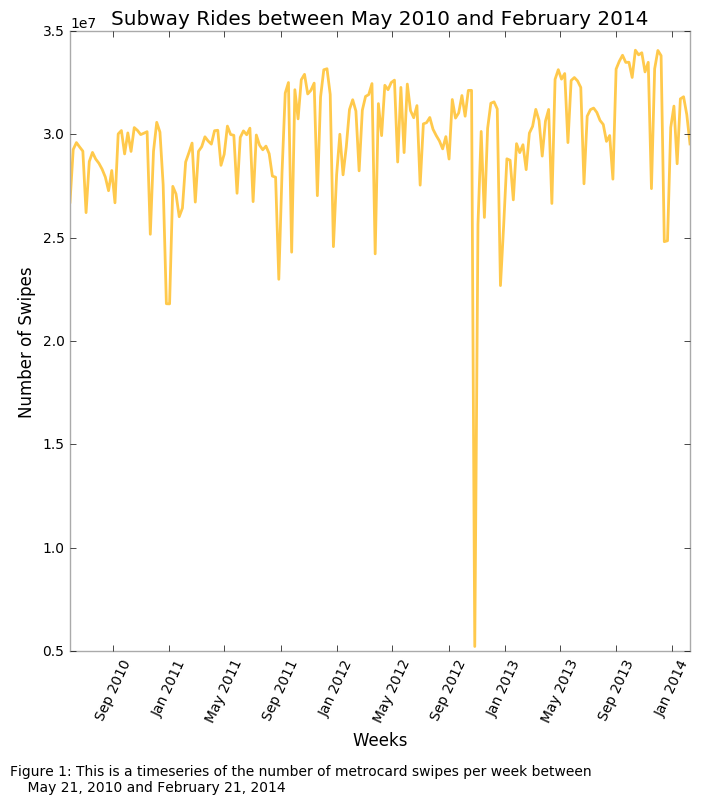

In [8]:
# Original timeseries plot
pl.figure(figsize = (8,8))
pl.plot(rng, MTAall, alpha = 0.7)
pl.xticks(rotation = '65')
pl.xlabel("Weeks", size='large')
pl.ylabel("Number of Swipes", size='large')
pl.title("Subway Rides between May 2010 and February 2014", size='x-large')
pl.figtext(.05, -0.05, '''Figure 1: This is a timeseries of the number of metrocard swipes per week between
    May 21, 2010 and February 21, 2014''')

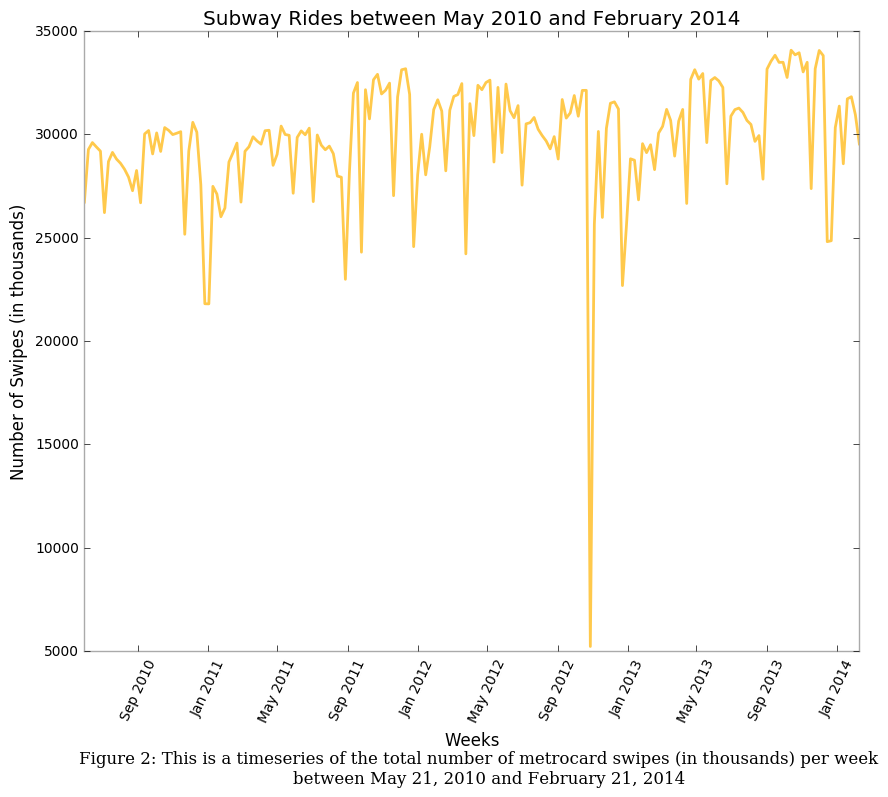

In [9]:
# Make a clealer plot  
pl.figure(figsize = (10,8))
pl.plot(rng, (MTAall / 1000), alpha = 0.7)
pl.xticks(rotation = '65')
pl.xlabel("Weeks", size='large')
pl.ylabel("Number of Swipes (in thousands)", size='large')
pl.title("Subway Rides between May 2010 and February 2014", size='x-large')
pl.figtext(.12, -0.04, '''Figure 2: This is a timeseries of the total number of metrocard swipes (in thousands) per week
    between May 21, 2010 and February 21, 2014''', fontname='serif', size="large", multialignment="center")

# Task 1: Event Detection

In [10]:
# For event detection, need to find an occurrence of ridership falling more than 3 standard deviations away from the mean

# from FDNYdeaths.ipynb, modified to find the mean, standard deviation, and 3-sigma thresholds for the data
mean = np.nanmean(MTAall)
print ("The mean number of rides per week is {:.2f}".format(np.nanmean(MTAall)))
print ("The standard deviation of rides per week is {:.2f}".format(np.nanstd(MTAall)))
thresholds = np.nanmean(MTAall) + 3 * np.nanstd(MTAall), np.nanmean(MTAall) - 3 * np.nanstd(MTAall)
print ("The 3-sigma thresholds for rides per week is {:.2f} and {:.2f}".format(*thresholds))

The mean number of rides per week is 29781349.87
The standard deviation of rides per week is 2983960.42
The 3-sigma thresholds for rides per week is 38733231.14 and 20829468.61


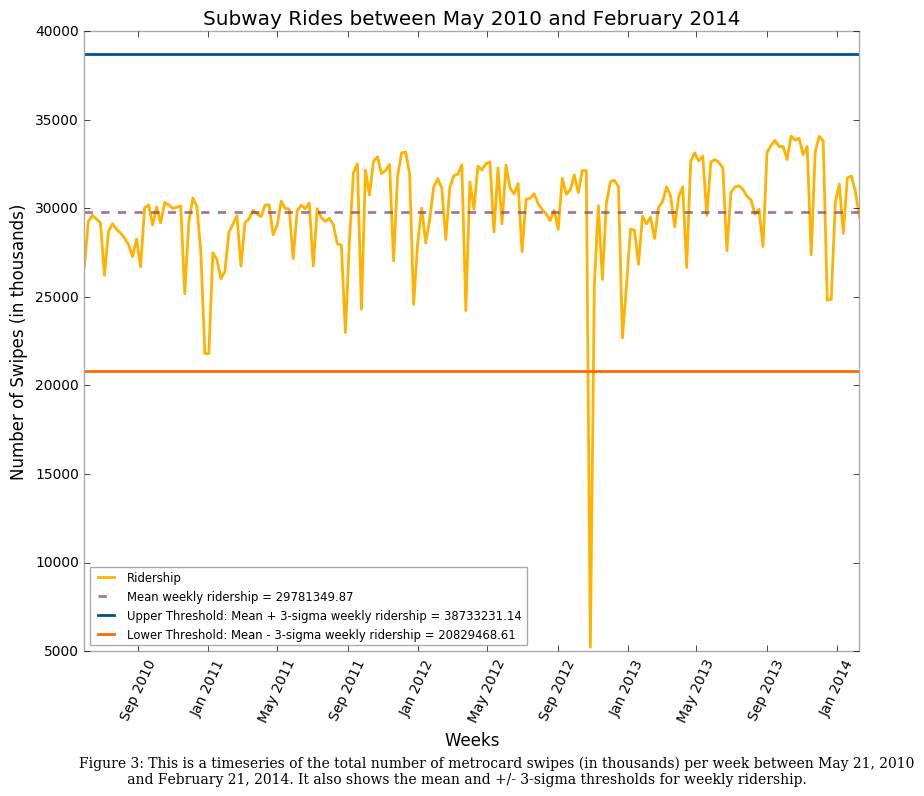

In [24]:
# Plot timeseries with 3-sigma thresholds
pl.figure(figsize = (10,8))
pl.plot(rng, (MTAall / 1000), label = "Ridership")
pl.xticks(rotation = '65')
pl.xlabel("Weeks", size='large')
pl.ylabel("Number of Swipes (in thousands)", size='large')
pl.title("Subway Rides between May 2010 and February 2014", size='x-large')
pl.figtext(.12, -0.04,
           '''Figure 3: This is a timeseries of the total number of metrocard swipes (in thousands) per week between May 21, 2010
           and February 21, 2014. It also shows the mean and +/- 3-sigma thresholds for weekly ridership.''',
           fontname='serif', multialignment="left")

# Plot mean
pl.plot((min(rng), max(rng)), ((mean / 1000), (mean / 1000)), '--', alpha = 0.7,
        label = 'Mean weekly ridership = %.2f' %mean)

# Plot upper threshold
pl.plot((min(rng), max(rng)), ((thresholds[0] / 1000), (thresholds[0] / 1000)),
        label="Upper Threshold: Mean + 3-sigma weekly ridership = %.2f" %thresholds[0])

# Plot lower threshold
pl.plot((min(rng), max(rng)), ((thresholds[1] / 1000), (thresholds[1] / 1000)),
        label="Lower Threshold: Mean - 3-sigma weekly ridership = %.2f" %thresholds[1])
pl.legend(loc="lower-left", fontsize="small")

In [12]:
# Find the date at which subway ridership was more than 3-sigma away from the mean
rng[np.where(MTAall < thresholds[1])] 

DatetimeIndex(['2012-10-28'], dtype='datetime64[ns]', freq=None)

### The significant drop in ridership occured during the week of October 28, 2012. This was the week that Hurricane Sandy hit New York City and surrounding areas. More specifically, October 28th was the exact date that New York Governor Andrew Cuomo ordered the MTA to stop service.

# Task 2: Trend Detection

In [21]:
# Get timeseries for each card type
MTAridetype = np.nansum(MTArides, axis=0)
print (MTAridetype.shape)

(23, 194)


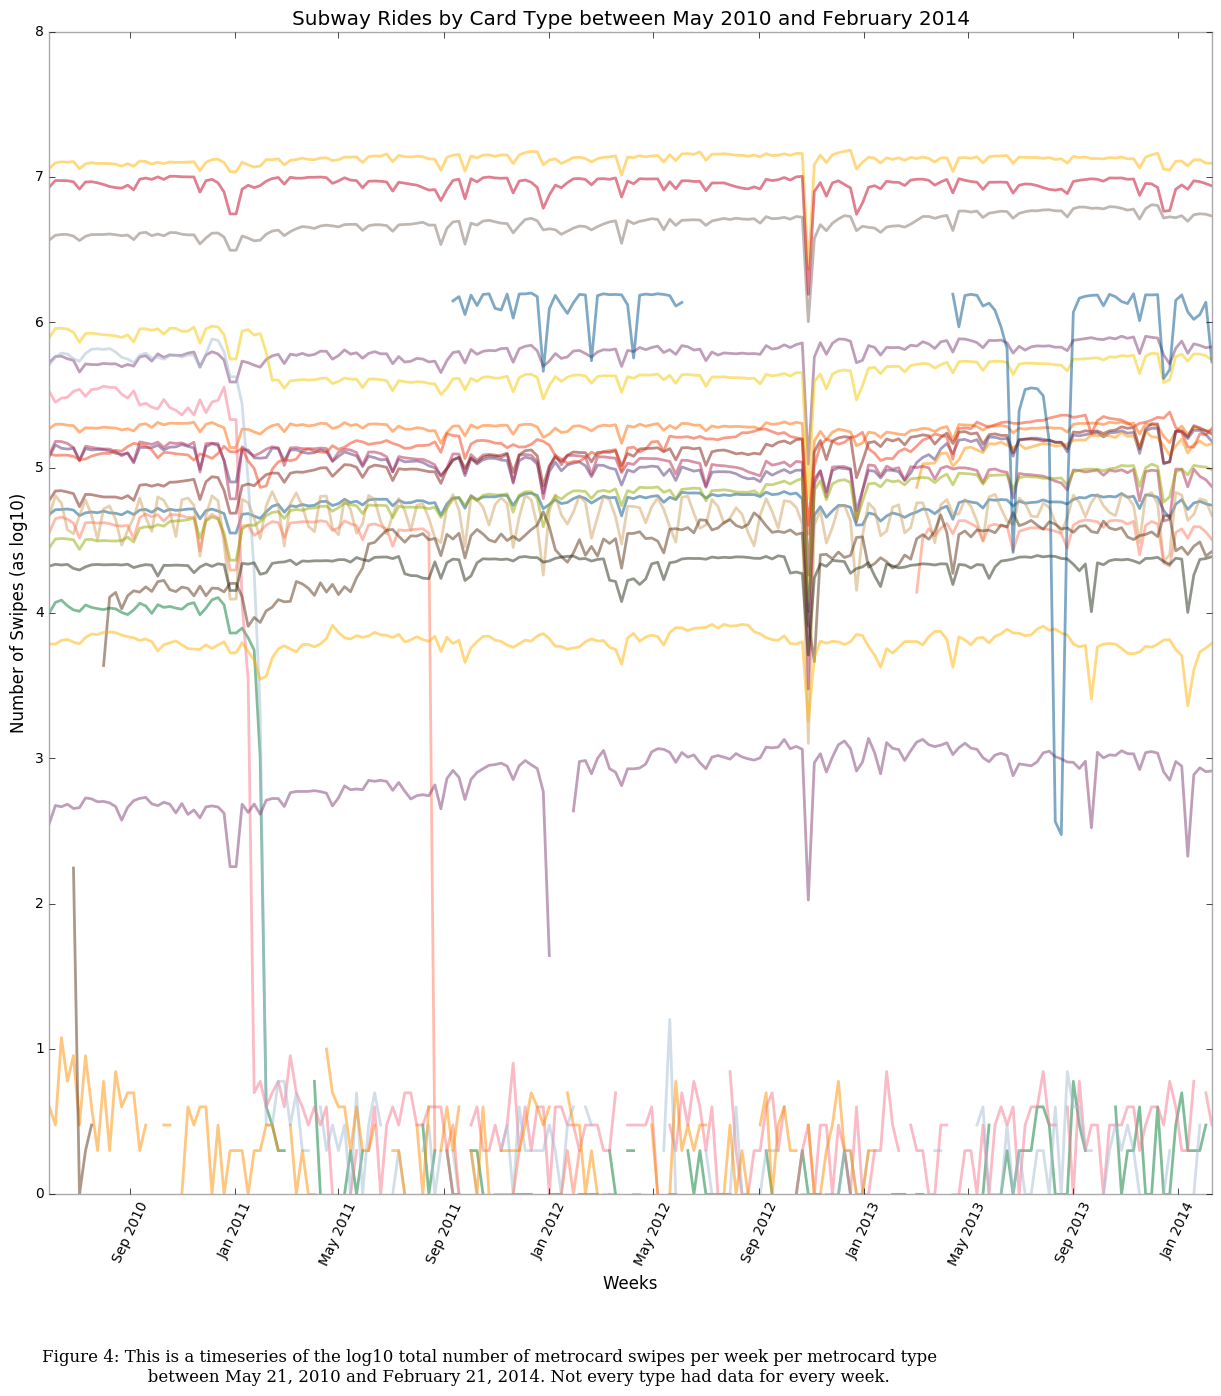

In [40]:
pl.figure(figsize = (15,15))
for i in range(0, len(ridetype)):
    pl.plot(rng, np.log10(MTAridetype[i]), alpha = 0.5)
pl.xticks(rotation = '65')
pl.xlabel("Weeks", size='large')
pl.ylabel("Number of Swipes (as log10)", size='large')
pl.title("Subway Rides by Card Type between May 2010 and February 2014", size='x-large')
pl.figtext(.12, -0.0001, 
           '''Figure 4: This is a timeseries of the log10 total number of metrocard swipes per week per metrocard type
           between May 21, 2010 and February 21, 2014. Not every type had data for every week.''', 
          fontname='serif', size="large", multialignment="center",)
pl.legend()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


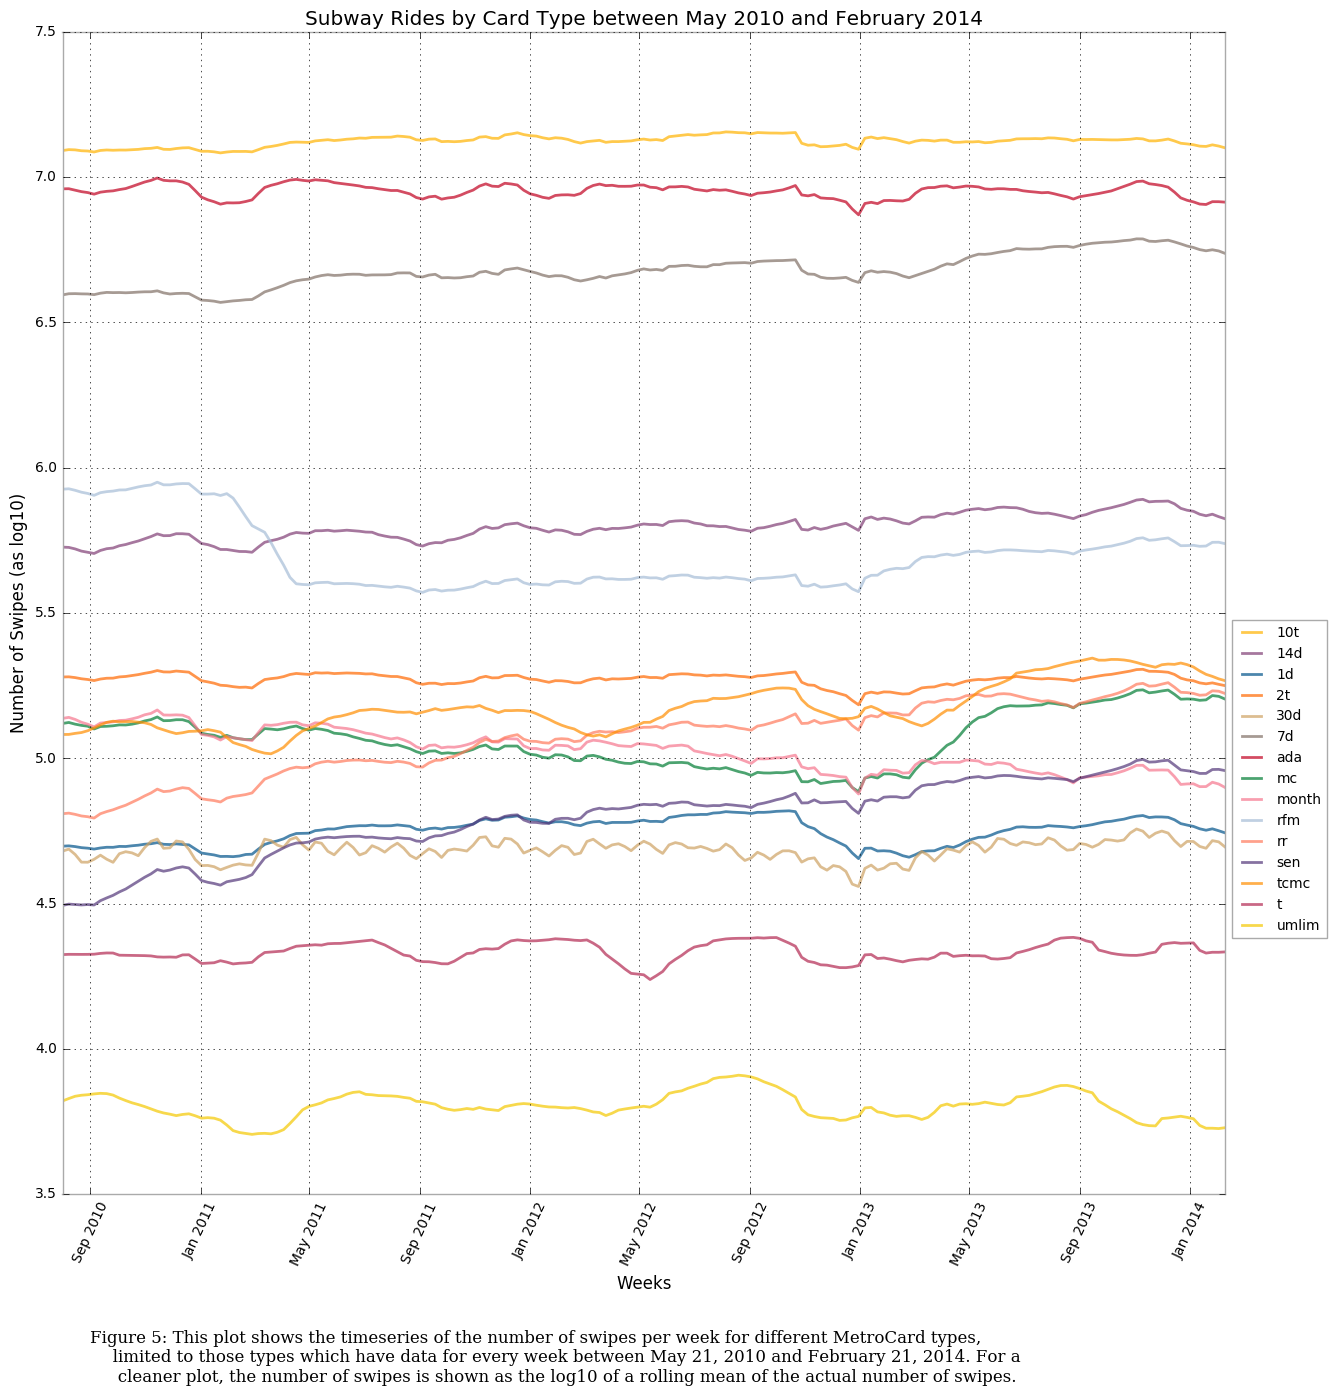

In [47]:
# Remove card types that do not have data for every week, and smooth the curves
pl.figure(figsize = (15,15))
for i in range(0, len(ridetype)):
    if np.min(MTAridetype[i]) > 0:
        pl.plot(rng, np.log10(pd.rolling_mean(MTAridetype[i], 10)), alpha = 0.7, label=ridetype[i])
pl.xticks(rotation = '65')
pl.xlabel("Weeks", size='large')
pl.ylabel("Number of Swipes (as log10)", size='large')
pl.title("Subway Rides by Card Type between May 2010 and February 2014", size='x-large')
pl.figtext(.12, -0.0001, 
           '''Figure 5: This plot shows the timeseries of the number of swipes per week for different MetroCard types, 
           limited to those types which have data for every week between May 21, 2010 and February 21, 2014. For a
           cleaner plot, the number of swipes is shown as the log10 of a rolling mean of the actual number of swipes.''', 
          fontname='serif', size="large", multialignment="center",)
pl.grid()
pl.legend(loc="lower-left", fontsize="medium", bbox_to_anchor=(1, 0.5))

In [91]:
# Find the card types which have steadily increased or decreased in ridership amount by comparing ridership in the first
# and last 10 weeks of the timeseries.
typeRatio = {}
for i in range(0, len(ridetype)):
    if np.min(MTAridetype[i]) > 0:
        start = MTAridetype[i, :10].sum()
        end = MTAridetype[i, -10:].sum()
        ratio = start/end # largest increase = smallest ratio, largest decrease = largest ratio
        ratio2 = end/start # largest increase = largest ratio, largest decrease = smallest ratio
        typeRatio[ridetype[i]] = (i, ratio)
        print (i, ridetype[i], ratio, ratio2)

0 10t 0.978667087302 1.02179792595
1 14d 0.79868054602 1.25206505277
2 1d 0.899810476622 1.11134513987
3 2t 1.07088927164 0.933803359956
4 30d 0.967317176485 1.03378708071
5 7d 0.719555117345 1.38974760362
6 ada 1.11130702032 0.899841341519
11 mc 0.824035088267 1.213540557
13 month 1.72794422105 0.578722384564
14 rfm 1.53938888675 0.649608431376
15 rr 0.385659649203 2.59295988592
16 sen 0.343713862169 2.90939676884
18 tcmc 0.652626042706 1.5322710627
19 t 0.978867204328 1.02158903228
20 umlim 1.23599634403 0.809063881804


### The card type with the greatest increase in ridership is the "senior citizen/disabled" type, and the card type with the greatest decrease in ridership is the "monthly' type.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


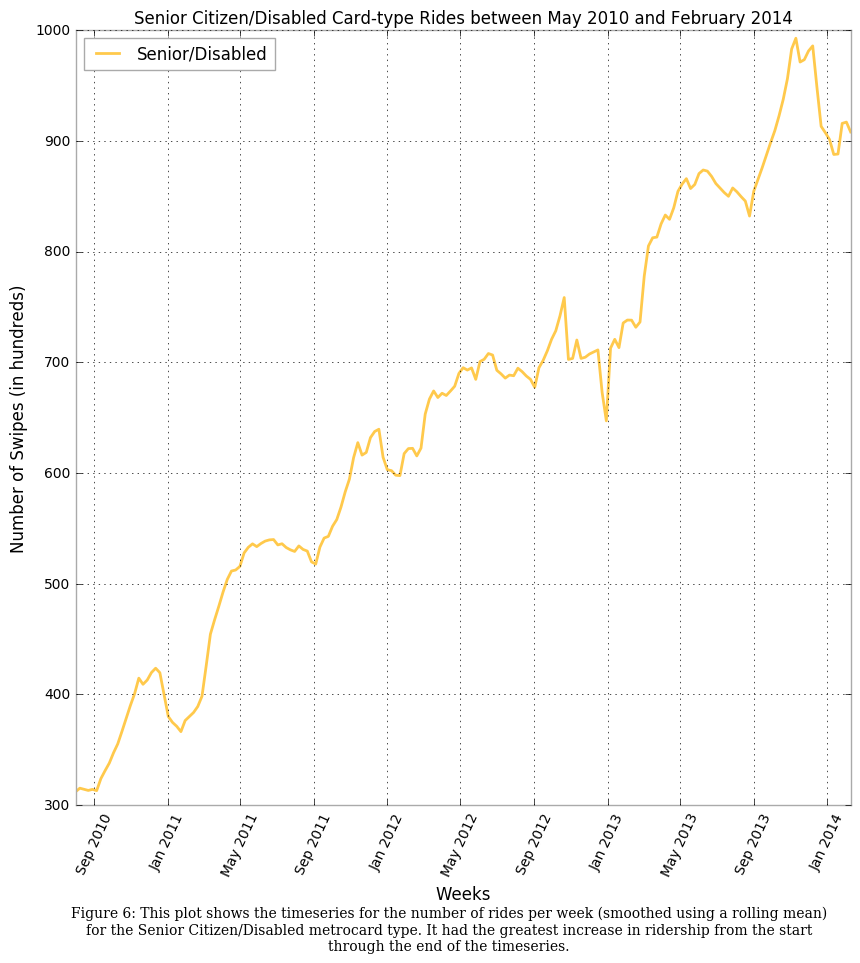

In [108]:
# Plot the greatest increase in ridership
pl.figure(figsize = (10,10))
for i in range(0, len(ridetype)):
    if np.min(MTAridetype[i]) > 0:
        start = MTAridetype[i, :10].sum()
        end = MTAridetype[i, -10:].sum()
        ratio = start/end
        if (ratio < 0.344):
            pl.plot(rng, (pd.rolling_mean(MTAridetype[i], 10) / 100), alpha = 0.7, label='Senior/Disabled')
pl.xticks(rotation = '65')
pl.xlabel("Weeks", size='large')
pl.ylabel("Number of Swipes (in hundreds)", size='large')
pl.title("Senior Citizen/Disabled Card-type Rides between May 2010 and February 2014", size='large')
pl.figtext(.12, -0.02, 
           '''Figure 6: This plot shows the timeseries for the number of rides per week (smoothed using a rolling mean)
for the Senior Citizen/Disabled metrocard type. It had the greatest increase in ridership from the start
through the end of the timeseries.''', 
          fontname='serif', size="medium", multialignment="center",)
pl.grid()
pl.legend(loc="upper left", fontsize="large")

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


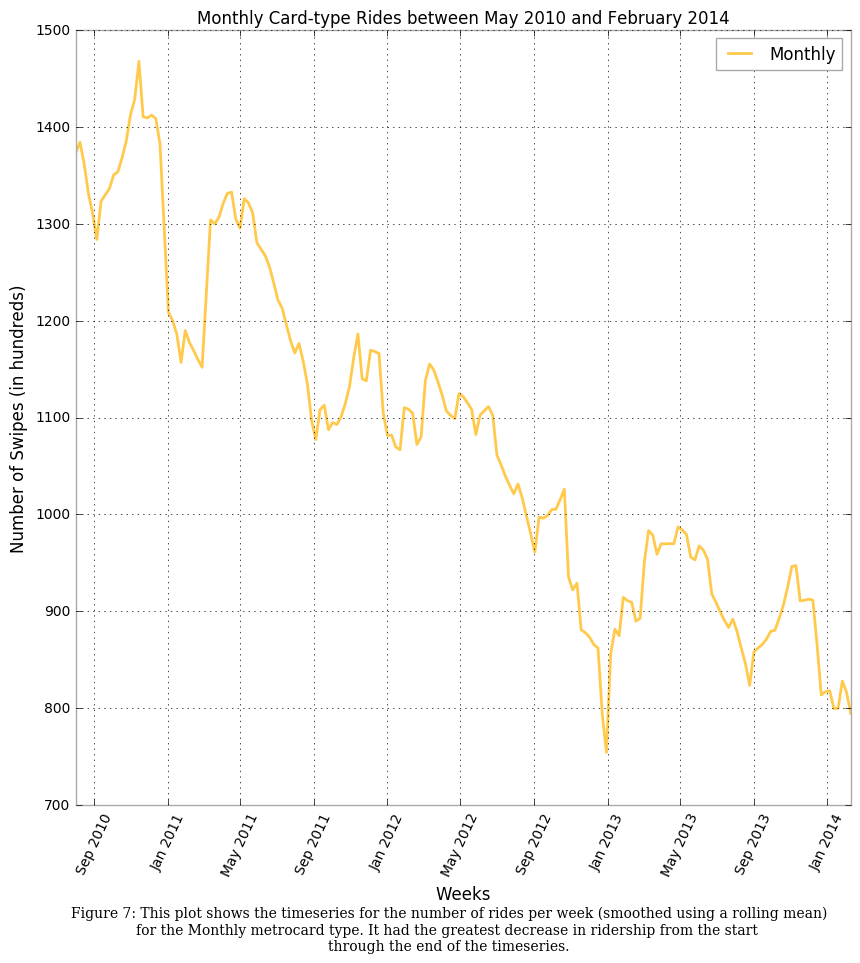

In [119]:
# Plot the greatest decrease in ridership
pl.figure(figsize = (10,10))
for i in range(0, len(ridetype)):
    if np.min(MTAridetype[i]) > 0:
        start = MTAridetype[i, :10].sum()
        end = MTAridetype[i, -10:].sum()
        ratio = start/end
        if (ratio > 1.7):
            pl.plot(rng, (pd.rolling_mean(MTAridetype[i], 10) / 100), alpha = 0.7, label='Monthly')
pl.xticks(rotation = '65')
pl.xlabel("Weeks", size='large')
pl.ylabel("Number of Swipes (in hundreds)", size='large')
pl.title("Monthly Card-type Rides between May 2010 and February 2014", size='large')
pl.figtext(.12, -0.02, 
           '''Figure 7: This plot shows the timeseries for the number of rides per week (smoothed using a rolling mean)
for the Monthly metrocard type. It had the greatest decrease in ridership from the start 
through the end of the timeseries.''', 
          fontname='serif', size="medium", multialignment="center",)
pl.grid()
pl.legend(loc="upper right", fontsize="large")

# Task 3: Annual Periodicity

In [121]:
# Get timeseries for each station
MTAstations = np.nansum(MTArides, axis=1)
print (MTAstations.shape)

(600, 194)


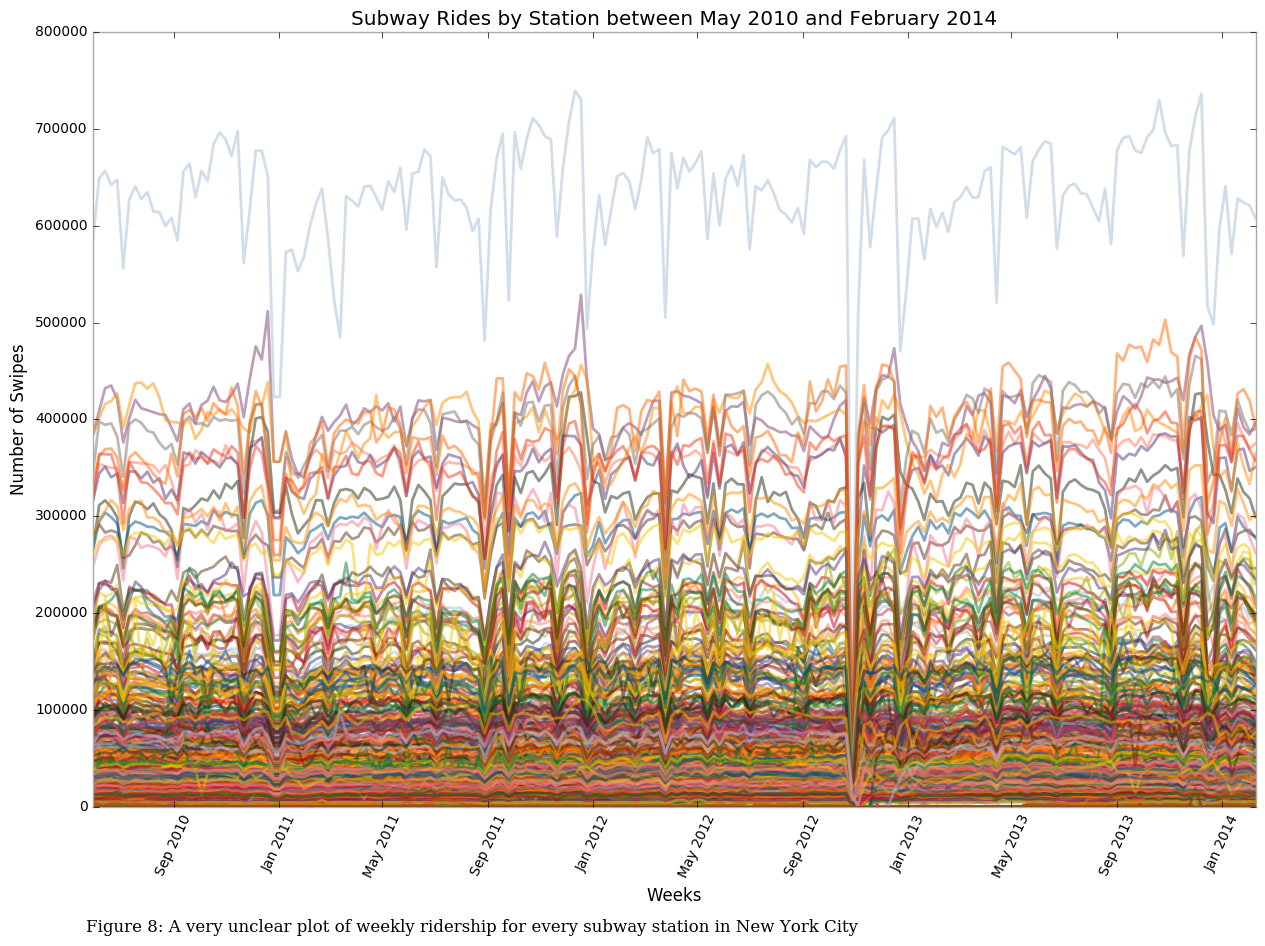

In [126]:
pl.figure(figsize = (15, 10))
for i in range(0, len(MTAstations)):
    pl.plot(rng, MTAstations[i], alpha = 0.5)
pl.xticks(rotation = '65')
pl.xlabel("Weeks", size='large')
pl.ylabel("Number of Swipes", size='large')
pl.title("Subway Rides by Station between May 2010 and February 2014", size='x-large')
pl.figtext(.12, -0.0001, 
           '''Figure 8: A very unclear plot of weekly ridership for every subway station in New York City''', 
          fontname='serif', size="large", multialignment="center",)

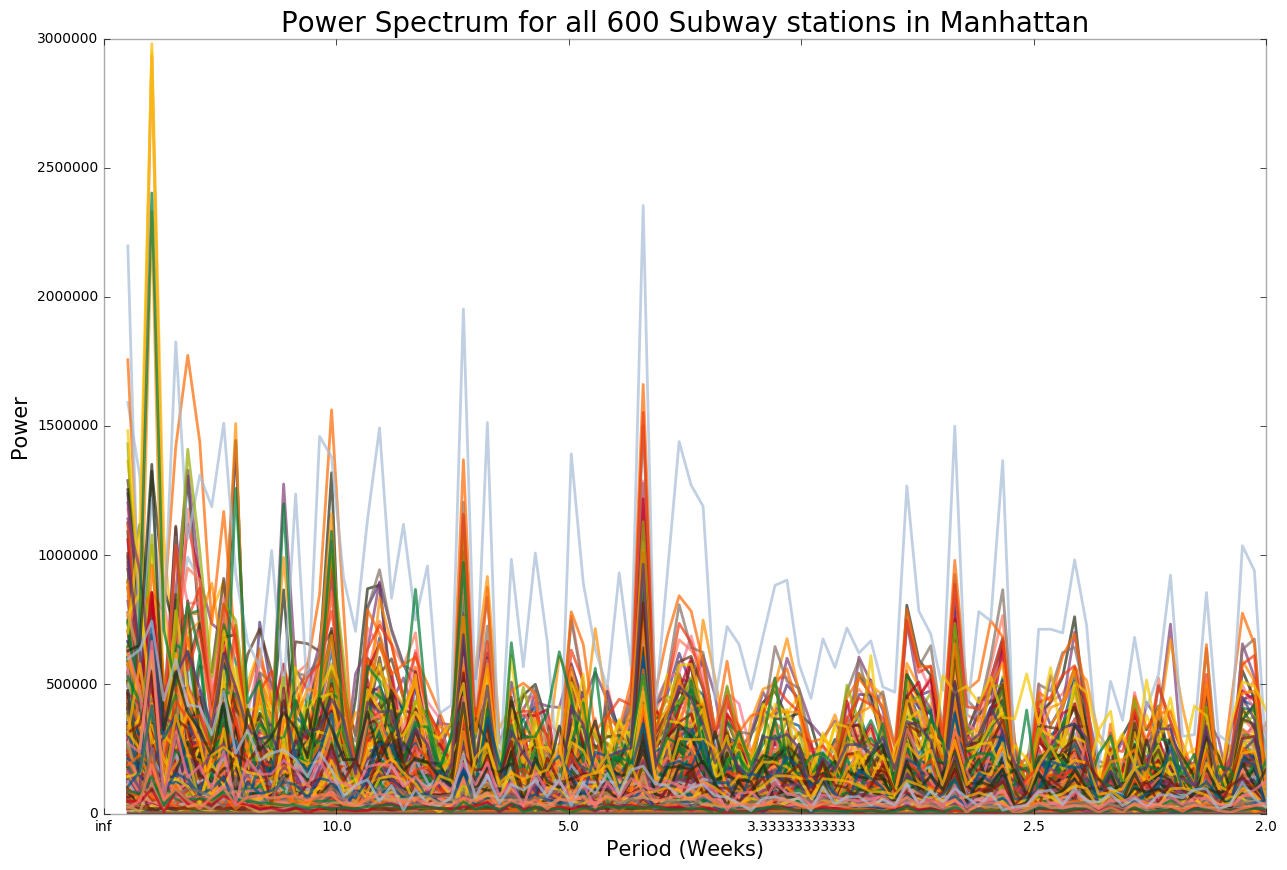

In [130]:
# Code from sbg389's notebook

N = len(MTAstations[1])
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
MTAstationsPeriodicity = {}
MTAstationsPower = {}

for i in range (len(MTAstations)):
    f = np.abs(np.fft.rfft(MTAstations[i]))
    ffreq = np.fft.rfftfreq(N, 1.0)
    MTAstationsPower[i]=(ffreq,f)
    ax.plot(ffreq[2:], (f[2:]), alpha = 0.7)
    MTAstationsPeriodicity[i]=((f[4]))

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()])
pl.xlabel("Period (Weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)

ax.set_title('Power Spectrum for all 600 Subway stations in Manhattan', fontsize=20)